### **MA5204: Aprendizaje de Máquinas**

**Departamento de Ingeniería Matemática, Universidad de Chile**

**Profesor:** Felipe Tobar

**Ayudantes:** Alejandro Cuevas, Mauricio Araneda, Mauricio Romero

## Procesos Gaussianos y performance de código

En este notebook:
1.- Formas de evaluar performance de código.
2.- Ejemplo de procesos Gaussianos.
3.- Automatic relevance determination (ARD) con procesos Gaussianos.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import fmin_l_bfgs_b as fmin  # minimizar
import time  # medir tiempo
from numba import jit  # decorador para compilar funciones a C

__Configuración para los gráficos__

In [2]:
sns.set_context('notebook', font_scale=1.4)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (12, 5)

# Mediciones de tiempo

Creamos una función para llenar una matrix de $n \times n$ con valores aleatorios, 
primero lo hace de forma iterativa con un ciclo doble, es decir llenando elemento por elemento.

In [3]:
def fill_matrix(n):
    """
    Llena una matriz aleatoria de n x n
    """
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = np.random.random()
    return A

In [4]:
ti = time.time()
fill_matrix(5000)
dt = time.time() - ti
print('Tiempo ejecución {} s'.format(dt))

Tiempo ejecución 10.72499966621399 s


Usamos la _magic line_ %timeit, en la cual si le pasamos una función, este la ejecuta un número de veces para obtener el tiempo promedio ejecución.

In [5]:
%timeit fill_matrix(5000)

10.2 s ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


__Intentemos mejorarla:__, Para esto usaremos el módulo numba, que mediante el decorador `@jit `, este decorador compila la función directamente a C.

In [6]:
@jit
def fill_matrix2(n):
    """ Llena una matriz aleatoria de n x n """
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = np.random.random()
    return A

In [7]:
ti = time.time()
fill_matrix2(5000)
dt = time.time() - ti
print('Tiempo ejecución {} s'.format(dt))

Tiempo ejecución 0.32302427291870117 s


En este caso redujimos de 10s a 1s

In [8]:
%timeit fill_matrix2(5000)

214 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


__podemos mejorar la función aún mas?__

¿Qué pasa si usamos la forma matricial del generador de número aleatorios?

In [9]:
def fill_matrix3(n):
    """ Llena una matriz aleatoria de n x n """
    A = np.random.random(size=(n, n))
    return A

In [10]:
ti = time.time()
fill_matrix3(5000)
dt = time.time() - ti
print('Tiempo ejecución {} s'.format(dt))

Tiempo ejecución 0.2812466621398926 s


In [11]:
%timeit fill_matrix3(5000)

252 ms ± 5.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


__hay que tener cuidado con @jit !__

In [12]:
cte = 10

In [13]:
def fn_nojit(x):
    return x + cte

In [14]:
@jit
def fn_conjit(x):
    return x + cte

In [15]:
print('Sin jit ', fn_nojit(3))
print('Con jit ', fn_conjit(3))

Sin jit  13
Con jit  13


__modifiquemos `cte`__

In [16]:
cte = 50

In [17]:
print('Sin jit ', fn_nojit(3))
print('Con jit ', fn_conjit(3))

Sin jit  53
Con jit  13


__¿Por que ocurre esto?__

# Procesos Gaussianos

Primero definimos el kernel y la negative log likelihood.

In [18]:
@jit
def K_SE(a, b, gamma=1. / 2, sigma=1):
    """
    Squared Exponential kernel
    Returns the gram matrix given by the kernel
    k(a,b) = sigma**2*exp(-gamma*(a-b)**2)
    Note that: gamma = 1 /(2*lengthscale**2)
    
    Inputs:
    a:(numpy array)   Array length n_a with first input
    b:(numpy array)   Array length n_b with second input
    gamma:(float)     Kernel parameter
    sigma:(float)     Kernel parameter, signal variance

    Returns:
    (numpy array) n_a X n_b gram matrix where element
    [i,j] = k(a[i], b[j])
    """
    # transform to array if a single point
    if np.ndim(a) == 0: a = np.array([a])
    if np.ndim(b) == 0: b = np.array([b])
    # create matrix
    gram = np.zeros((len(a), len(b)))
    # compute
    for i, va in enumerate(a):
        for j, vb in enumerate(b):
            gram[i, j] = sigma**2 * np.exp(-gamma * (va - vb)**2)
    # condition if a single point
    if (len(a) == 1) or (len(b) == 1):
        return gram.reshape(-1)
    else:
        return gram


def like_SE(theta, y, t):
    """
    Computes negative log-likelihood when using SE kernel
    Designed for training w.r.t log of hyperparameters, not imposing restrictions on solver
    
    Inputs:
    theta:(numpy array) Kernel parameters, sigma_noise | gamma | sigma_signal
    y:(numpy array)     Array of observations-length n
    t:(numpy array)     Array of time-length n
    
    Returns:
    (float) Computed nll
    """
    sigma_noise, gamma_1, sig_1 = np.exp(theta)
    Gram = K_SE(
        t, t, gamma=gamma_1,
        sigma=sig_1) + sigma_noise**2 * np.identity(len(t))
    # inverse with cholesky
    cGg = np.linalg.cholesky(Gram)
    invGram = np.linalg.inv(cGg.T) @ np.linalg.inv(cGg)
    # nll
    nll = 2 * np.log(np.diag(cGg)).sum() + y.T @ (invGram @ y) 
    return 0.5 * nll + 0.5 * len(y) * np.log(2 * np.pi)

Con esto, dado los parametros del kernel y un vector de tiempo, podemos obtener muestras del proceso.

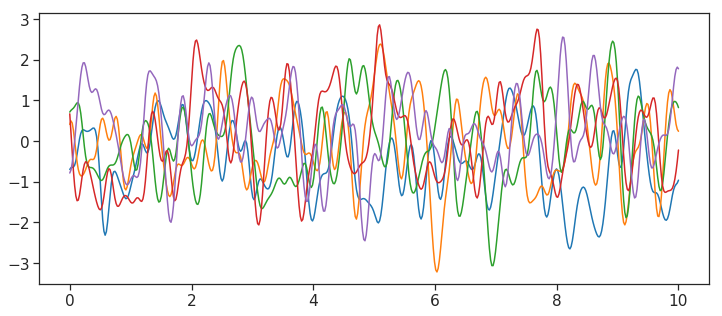

In [19]:
# lenghtscale
l = .1
# transformar a gamma
gamma = 1 / (2 * l**2)

# vector de tiempo a evaluar
t = np.linspace(0, 10, 500)

samples = np.random.multivariate_normal(mean=np.zeros(len(t)) ,cov=K_SE(t, t, gamma), size=5)
plt.plot(t, samples.T);

## Cargar datos

Carguemos los datos del precio de la lana y veamos si podemos interpolar con un GP


Notación útil
`np.dot(a, b) = a.dot(b) = a @ b`

In [20]:
# random seed
np.random.seed(123)
# cargamos datos
data = np.loadtxt('../datos/wool.csv', delimiter=',')

t = data[:, 0]
y = data[:, 1]

# tomamos solo el 15% de los datos
prop = 0.15
i_obs = np.random.choice(np.arange(len(t)), int(prop * len(t)), replace=False)

# asignamos observaciones
t_obs = t[i_obs]
y_obs = y[i_obs]
n_obs = len(i_obs)

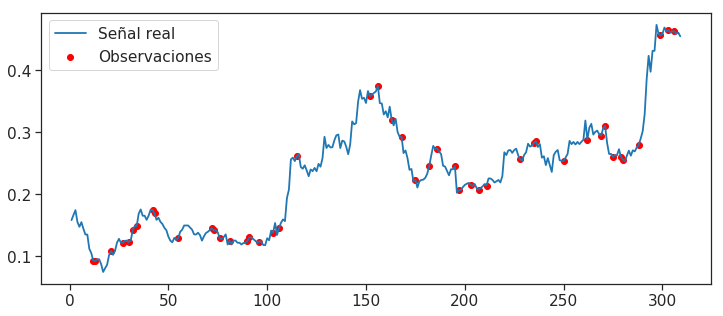

In [21]:
# Graficamos
plt.plot(t, y, label='Señal real', lw=1.8)
plt.scatter(t_obs, y_obs, c='r', label='Observaciones')
plt.legend()

## Prueba a mano

Antes de optimizar los hyperparámetros del kernel, fijemos parametros a mano y luego veamos que tan bien se ajusta.

Para esto, nuestros input de train seran $t_{obs}, y_{obs}$ y los puntos sobre el cual haremos test será $t$.

In [22]:
# hyperparametros elegidos a mano
# varianza ruido
sigma_n_GP_test = .001
# 
gamma_test = .01
sigma_test = .1

print('Negative log-likelihood para hiperámetros escogidos: ',
      like_SE([sigma_n_GP_test, gamma_test, sigma_test], y_obs, t_obs))

Negative log-likelihood para hiperámetros escogidos:  61.129929273735016


In [23]:
# covarianza prior
cov = K_SE(t, t, gamma=gamma_test, sigma=sigma_test)

# covarianza prior de las obs
cov_obs = K_SE(t_obs, t_obs, gamma=gamma_test, sigma=sigma_test)

# K(x*, x) evaluación kernel entre obs y test points
K_star = K_SE(t, t_obs, gamma=gamma_test, sigma=sigma_test)

# cholesky
cGg = np.linalg.cholesky(cov_obs + sigma_n_GP_test**2 * np.identity(n_obs))

# inversa de la matrix de cov(gram)
invGramg = np.linalg.inv(cGg.T) @ np.linalg.inv(cGg)

# matriz temporal K(x*, x) (K(x, x) + sigma * I)^-1
temp = K_star @ invGramg

# media de la posterior
m_post = temp @ y_obs

# covarianza de la posterior
sigma_post = np.diag(cov - temp @ K_star.T)
std_dev = np.sqrt(sigma_post)

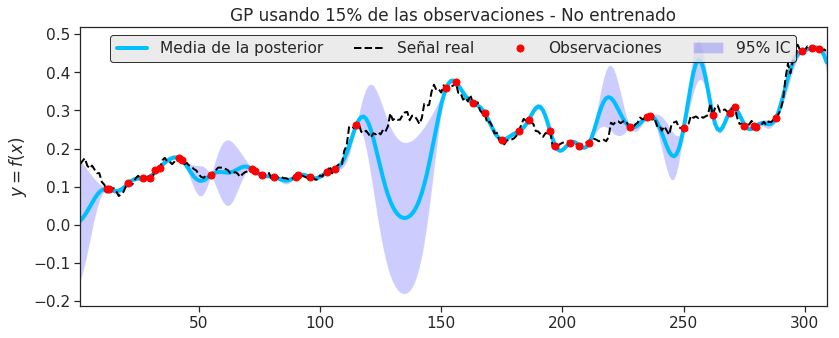

In [24]:
# grafico
plt.plot(t, m_post, c='#00BFFF', lw=4, label='Media de la posterior')
plt.fill_between(
    t,
    m_post - 2 * std_dev,
    m_post + 2 * std_dev,
    facecolor='blue',
    alpha=0.2,
    label='95% IC')
plt.plot(t, y, color='black', ls='--', lw=2, label='Señal real')
plt.plot(t_obs, y_obs, 'r.', ms=14, label='Observaciones')
leg = plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
frame = leg.get_frame()
frame.set_facecolor('0.9')
plt.ylabel(r'$y=f(x) + \eta$')
plt.ylabel(r'$y=f(x)$')
plt.xlim(t[0], t[-1])
plt.title('GP usando {}% de las observaciones - No entrenado'.format(int(prop*100)))
plt.tight_layout()

## Entrenamiento

Al entrenar obtenemos los hyperparametros del kernel, minimizando la NLL

In [25]:
# argumentos fijos funcion
args = (y_obs, t_obs)

# punto inicial
params0 = np.asarray([1, .1, 1])
X0 = np.log(params0)

print('Condicion inicial optimizador: ', params0)

time_GP = time.time()
X_opt, f_GP, data = fmin(
    like_SE,
    X0,
    None,
    args,
    approx_grad=True,
    disp=1,
    factr=0.00000001 / (2.22E-12),
    maxiter=1000)
time_GP = time.time() - time_GP

print("Tiempo entrenamiento {:.4f} (s)".format(time_GP))

sigma_n_GP_opt, gamma_opt, sigma_opt = np.exp(X_opt)
print('Hiperparametros encontrados: ', np.exp(X_opt), 'NLL: ', f_GP)

Condicion inicial optimizador:  [1.  0.1 1. ]
Tiempo entrenamiento 0.2003 (s)
Hiperparametros encontrados:  [0.01010119 0.00206153 0.20259543] NLL:  -83.50311388992233


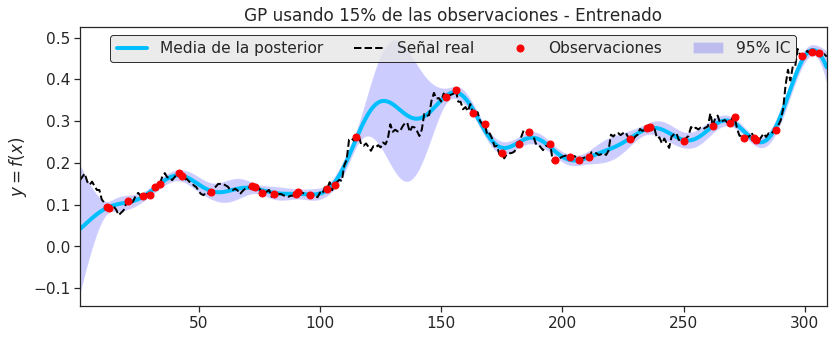

In [26]:
# covarianza prior
cov = K_SE(t, t, gamma=gamma_opt, sigma=sigma_opt)

# covarianza prior de las obs
cov_obs = K_SE(t_obs, t_obs, gamma=gamma_opt, sigma=sigma_opt)

# K(x*, x) evaluación kernel entre obs y test points
K_star = K_SE(t, t_obs, gamma=gamma_opt, sigma=sigma_opt)

# cholesky
cGg = np.linalg.cholesky(cov_obs + sigma_n_GP_opt**2 * np.identity(n_obs))

# inversa de la matriz de cov (gram)
invGramg = np.linalg.inv(cGg.T) @ np.linalg.inv(cGg)

# matriz auxiliar K(x*, x) (K(x, x) + sigma * I)^-1
temp = K_star @ invGramg

# media posterior
m_post = temp @ y_obs

# cov posterior
sigma_post = np.diag(cov - temp @ K_star.T)
std_dev = np.sqrt(sigma_post)

# grafico
plt.plot(t, m_post, c='#00BFFF', lw=4, label='Media de la posterior')
plt.fill_between(
    t,
    m_post - 2 * std_dev,
    m_post + 2 * std_dev,
    facecolor='blue',
    alpha=0.2,
    label='95% IC')
plt.plot(t, y, color='black', ls='--', lw=2, label='Señal real')
plt.plot(t_obs, y_obs, 'r.', ms=14, label='Observaciones')
leg = plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
frame = leg.get_frame()
frame.set_facecolor('0.9')
plt.ylabel(r'$y=f(x) + \eta$')
plt.ylabel(r'$y=f(x)$')
plt.xlim(t[0], t[-1])
plt.title('GP usando {}% de las observaciones - Entrenado'.format(int(prop*100)))
plt.tight_layout()

## Señal más grande

Usamos una señal más grande para notar la diferencia entre usar @jit o no al evaluar el kernel.

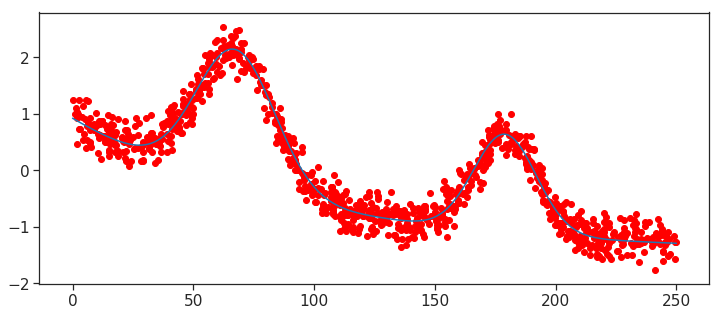

In [27]:
np.random.seed(666)

n_points = 10000
t = np.linspace(0, 250, n_points)
b = np.array([
    9.877821e1, 1.049727e-2, 1.004899e2, 6.748111e1, 2.312977e1, 7.19945e1,
    1.789980e2, 1.838938e1
])
y = b[0] * np.exp(-b[1] * t) + b[2] * np.exp(
    -(t - b[3])**2 / b[4]**2) + b[5] * np.exp(-(t - b[6])**2 / b[7]**2)
y = (y - y.mean()) / y.std()
y_real = y.copy()

percent = 0.1
i_obs = np.random.choice(
    np.arange(0, n_points, 1), int(percent * n_points), replace=False)

# Añadimos ruido
###########################
y += np.random.normal(scale=0.2, size=n_points)
###########################

y_obs = y[i_obs]
t_obs = t[i_obs]
n_obs = len(y_obs)

plt.plot(t, y_real)
plt.scatter(t_obs, y_obs, c='r')

In [28]:
n_obs

1000

In [29]:
# fixed args of function
args = (y_obs, t_obs)

# initial point
params0 = np.asarray([1, .1, 1])
X0 = np.log(params0)

print('Condicion inicial optimizador: ', params0)

time_GP = time.time()
X_opt, f_GP, data = fmin(
    like_SE,
    X0,
    None,
    args,
    approx_grad=True,
    disp=1,
    factr=0.00000001 / (2.22E-12),
    maxiter=1000)
time_GP = time.time() - time_GP

print("Tiempo entrenamiento {:.4f} (s)".format(time_GP))

sigma_n_GP_opt, gamma_opt, sigma_opt = np.exp(X_opt)
print('Hiperparametros encontrados: ', np.exp(X_opt), 'NLL: ', f_GP)

Condicion inicial optimizador:  [1.  0.1 1. ]
Tiempo entrenamiento 16.7551 (s)
Hiperparametros encontrados:  [0.19786803 0.00129856 0.95522094] NLL:  -150.42442045770804


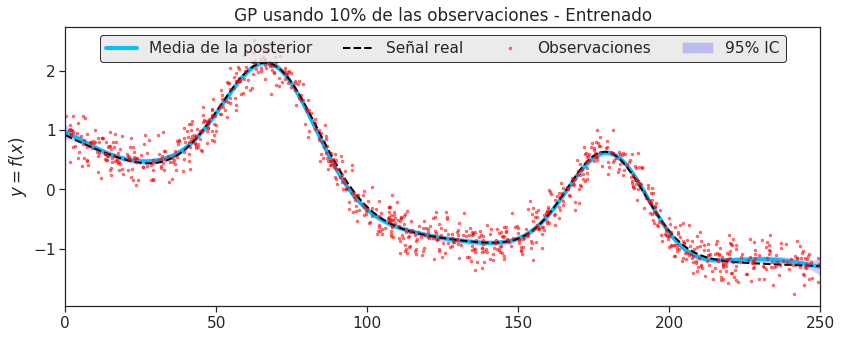

In [30]:
# process prior covariance 
cov = K_SE(t, t, gamma=gamma_opt, sigma=sigma_opt)

# observations prior covariance 
cov_obs = K_SE(t_obs, t_obs, gamma=gamma_opt, sigma=sigma_opt)

# K(x*, x) kernel evaluation between obs and test points
K_star = K_SE(t, t_obs, gamma=gamma_opt, sigma=sigma_opt)

# cholesky
cGg = np.linalg.cholesky(cov_obs + sigma_n_GP_opt**2 * np.identity(n_obs))

# inverse covariance matrix (gram)
invGramg = np.linalg.inv(cGg.T) @ np.linalg.inv(cGg)

# temporal matrix K(x*, x) (K(x, x) + sigma * I)^-1
temp = K_star @ invGramg
# posterior mean
m_post = temp @ y_obs
# posterior covariance
sigma_post = np.diag(cov - temp @ K_star.T)
std_dev = np.sqrt(sigma_post)

# plot estimation, obs and real data
plt.plot(t, m_post, c='#00BFFF', lw=4, label='Media de la posterior')
plt.fill_between(
    t,
    m_post - 2 * std_dev,
    m_post + 2 * std_dev,
    facecolor='blue',
    alpha=0.2,
    label='95% IC')
plt.plot(t, y_real, color='black', ls='--', lw=2, label='Señal real')
plt.plot(t_obs, y_obs, 'r.', ms=5, label='Observaciones', alpha=0.5)
leg = plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
frame = leg.get_frame()
frame.set_facecolor('0.9')
plt.ylabel(r'$y=f(x) + \eta$')
plt.ylabel(r'$y=f(x)$')
plt.xlim(t[0], t[-1])
plt.title('GP usando {}% de las observaciones - Entrenado'.format(int(percent*100)))
plt.tight_layout()

## ARD

Automatic relevance detarmination, es un tipo de kernel, o más bien una modificación para hacer hacer selección de features o atributos.

La idea detras es usar un kernel RBF distinto para cada feature, es decir cada uno sera un kernel RBF con un lenghtscale distinto, si el lenghtscale es suficientemente grande, el GP será invariante al cambio en esa feature, lo que quiere decir que no afecta a la predicción. Con los lenghtscales obtenidos se puede hacer un ranking de features.

In [31]:
from sklearn.datasets import load_boston

datos de calidad de aire disponibles [aca](https://archive.ics.uci.edu/ml/datasets/Air+Quality)


descripción boston [aca](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)

In [32]:
boston = load_boston()
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [33]:
boston['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [34]:
t = boston['data']
y = boston['target']

print(t.shape)
print(y.shape)

(506, 13)
(506,)


In [35]:
y = (y - y.mean()) / y.std()

t = (t - t.mean()) / t.std()
n_points = len(y)

percent = 0.2
i_obs = np.random.choice(
    np.arange(0, n_points, 1), int(percent * n_points), replace=False)

y_obs = y[i_obs]
t_obs = t[i_obs, :]
n_obs = len(y_obs)

In [39]:
@jit
def K_SE_ARD(a, b, gamma, sigma=1):
    """
    Squared Exponential kernel
    Returns the gram matrix given by the kernel
    k(a,b) = sigma**2*exp(-gamma*(a-b)**2)
    Note that: gamma = 1 /(2*lengthscale**2)
    
    Inputs:
    a:(numpy array)      Array length n_a with first input
    b:(numpy array)      Array length n_b with second input
    gamma:(float)        Kernel parameter
    sigma:(numpy array)  Kernel parameter, signal variance

    Returns:
    (numpy array) n_a X n_b gram matrix where element
    [i,j] = k(a[i], b[j])
    """
    # transform to array if a single point
    if np.ndim(a) == 0: a = np.array([a])
    if np.ndim(b) == 0: b = np.array([b])
    # create matrix
    gram = np.zeros((a.shape[0], b.shape[0]))
    # compute
    ard = np.diag(gamma)
    for i, va in enumerate(a):
        for j, vb in enumerate(b):
            norm = (va - vb).T @ ard @ (va - vb)
            gram[i, j] = np.exp(-0.5 * norm)
    # condition if a single point
    if (len(a) == 1) or (len(b) == 1):
        return gram.reshape(-1)
    else:
        return gram
    
def like_SE(theta, y, t):
    """
    Computes negative log-likelihood when using SE kernel
    Designed for training w.r.t log of hyperparameters, not imposing restrictions on solver
    
    Inputs:
    theta:(numpy array) Kernel parameters, sigma_noise | gamma | sigma_signal
    y:(numpy array)     Array of observations-length n
    t:(numpy array)     Array of time-length n
    
    Returns:
    (float) Computed nll
    """
    sigma_noise = np.exp(theta)[0]
    gamma_1 = np.exp(theta)[1:-1]
    sig_1 = np.exp(theta)[-1]
    
    Gram = K_SE_ARD(
        t, t, gamma=gamma_1,
        sigma=sig_1) + (sigma_noise + 1e-10)**2 * np.identity(len(t))
    # inverse with cholesky
    cGg = np.linalg.cholesky(Gram)
    invGram = np.linalg.inv(cGg.T) @ np.linalg.inv(cGg)
    # nll
    nll = 2 * np.log(np.diag(cGg)).sum() + y.T @ (invGram @ y) 
    return 0.5 * nll + 0.5 * len(y) * np.log(2 * np.pi)

In [41]:
# hand-chosen hyperparameter
sigma_n_GP_test = .1
gamma_test = np.ones(t.shape[1]) * 1
sigma_test = 1
theta = np.r_[sigma_n_GP_test, gamma_test, sigma_test]

print('Negative log-likelihood para hiperámetros escogidos: ',
      like_SE(theta, y_obs, t_obs))

Negative log-likelihood para hiperámetros escogidos:  138.58638368544808


In [42]:
# fixed args of function
args = (y_obs, t_obs)

# initial point
params0 = theta
X0 = np.log(params0)

print('Condicion inicial optimizador: ', params0)

time_GP = time.time()
X_opt, f_GP, data = fmin(
    like_SE,
    X0,
    None,
    args,
    approx_grad=True,
    disp=1,
    factr=0.00000001 / (2.22E-12),
    maxiter=100)
time_GP = time.time() - time_GP

print("Tiempo entrenamiento {:.4f} (s)".format(time_GP))

sigma_n_GP_opt = np.exp(X_opt)[0]
gamma_opt = np.exp(X_opt)[1:-1]
sigma_opt = np.exp(X_opt)[-1]

print('Sigma ruido optimo', sigma_n_GP_opt)
print('gamma opt', gamma_opt)
print('lenghtscale opt', np.sqrt(gamma_opt / 2))
print('sigma señal opt', sigma_opt)
print('NLL', f_GP)

Condicion inicial optimizador:  [0.1 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
Tiempo entrenamiento 97.3349 (s)
Sigma ruido optimo 0.23960278573039517
gamma opt [5.66697173e+02 4.84075454e-03 1.92823014e-01 6.63398688e+00
 9.99955462e-01 7.83769344e+03 2.53788193e-09 3.58997638e+01
 3.38230098e+02 1.91267415e-06 3.81328271e-02 1.81491325e+00
 3.99563065e+02]
lenghtscale opt [1.68329613e+01 4.91973299e-02 3.10502024e-01 1.82126150e+00
 7.07091034e-01 6.26006926e+01 3.56221976e-05 4.23673010e+00
 1.30044242e+01 9.77924883e-04 1.38081185e-01 9.52605179e-01
 1.41344095e+01]
sigma señal opt 1.0
NLL 57.7657787214478


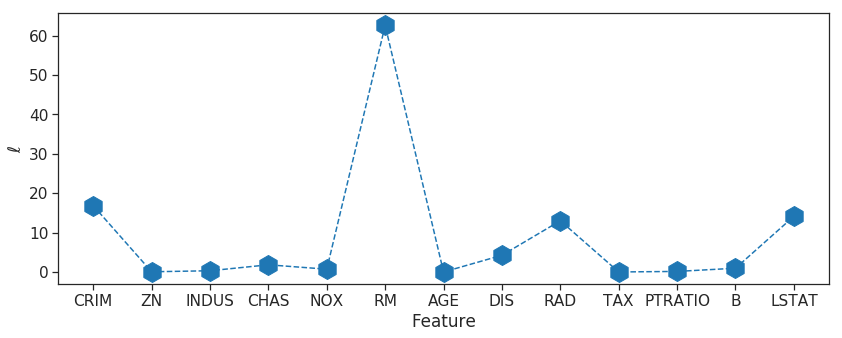

In [43]:
plt.plot(np.arange(1, len(gamma_opt) + 1), np.sqrt(gamma_opt / 2), '--h', ms=20)
plt.xlabel('Feature')
plt.ylabel(r'$\ell$')
plt.xticks(np.arange(1, len(gamma_opt) + 1), boston['feature_names'])

plt.tight_layout()

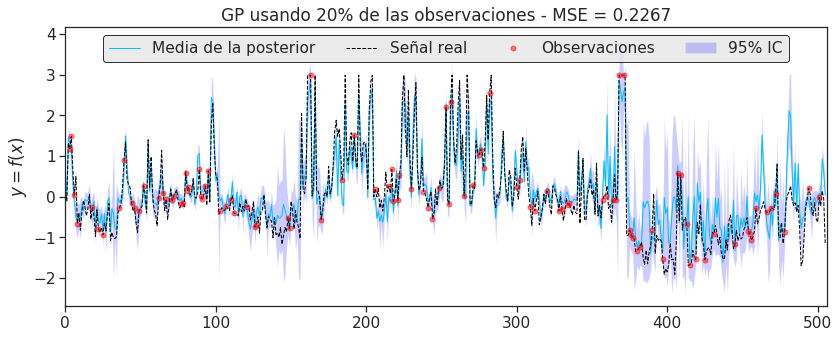

In [44]:
# process prior covariance
cov = K_SE_ARD(t, t, gamma=gamma_opt, sigma=sigma_opt)

# observations prior covariance
cov_obs = K_SE_ARD(t_obs, t_obs, gamma=gamma_opt, sigma=sigma_opt)

# K(x*, x) kernel evaluation between obs and test points
K_star = K_SE_ARD(t, t_obs, gamma=gamma_opt, sigma=sigma_opt)

# cholesky
cGg = np.linalg.cholesky(cov_obs + sigma_n_GP_opt**2 * np.identity(n_obs))

# inverse covariance matrix (gram)
invGramg = np.linalg.inv(cGg.T) @ np.linalg.inv(cGg)

# temporal matrix K(x*, x) (K(x, x) + sigma * I)^-1
temp = K_star @ invGramg
# posterior mean
m_post = temp @ y_obs

# posterior covariance
sigma_post = np.diag(cov - temp @ K_star.T)
std_dev = np.sqrt(sigma_post)

# plot estimation, obs and real data
plt.plot(m_post, c='#00BFFF', lw=1, label='Media de la posterior')
plt.fill_between(
    np.arange(len(m_post)),
    m_post - 2 * std_dev,
    m_post + 2 * std_dev,
    facecolor='blue',
    alpha=0.2,
    label='95% IC')
plt.plot(y, color='black', ls='--', lw=1, label='Señal real')
plt.plot(i_obs, y_obs, 'r.', ms=10, label='Observaciones', alpha=0.5)
leg = plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
frame = leg.get_frame()
frame.set_facecolor('0.9')
plt.ylabel(r'$y=f(x) + \eta$')
plt.ylabel(r'$y=f(x)$')
plt.xlim(0, len(y))
plt.title('GP usando {}% de las observaciones - MSE = {:.4}'.format(
    int(percent * 100), ((m_post - y)**2).mean()))
plt.tight_layout()

# plt.savefig('gp_boston.pdf')